# Implementación de autoencoders en Python con Keras

Exploraremos las redes neuronales __autoencoders__ e implementaremos una red combinando CNN con auntoencoder para eliminar ruido de imágenes, obtenidas del dataset noMNIST, utilizando Python y Keras.

Este tutorial está adaptado de [Implementing Autoencoders in Keras: Tutorial](https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial) de [Aditya Sharma](https://www.datacamp.com/profile/adityasharma101993)


## Autoencoder

Un autoencoder es un algoritmo de _machine learning_ __no supervisado__ que se entrena para intentar copiar su _input_ en su _output_. Internamente, tiene una capa oculta $h$ que describe un __código__ usado para representar el __input__. 
Se puede considerar que la red está compuesta de dos partes: una función _encoder_ (o codificadora) $h = f(x)$ y una función _decoder_ (o descodificadora) que produce una reconstrucción $r = g(h)$.

Si un autoencoder tiene éxito en aprender que $g(f(x)) = x$ para todos los _inputs_, simplemente no resulta útil. En vez de eso, los autoencoders se diseñan para que no sean capaces de aprender a copiar exactamente, sino que se restringen para permitirles copiar solo aproximadamente algo que parezca los datos de entrada. Dado que el modelo está forzado a priorizar algunos aspectos que deben ser copiados, a menudo aprenden propiedades útiles de los datos.

Los autoencoders funcionan de una forma parecida a otras técnicas de reducción dimensional, como por ejemplo el análisis de componentes principales (PCA). Proyectan los datos desde un espacio de altas dimensiones a una de menor dimensión utilizando una transformación lineal e intentando preservar las características (_features_) importantes de los datos, eliminando las no esenciales.

Sin emabrgo, la mayor diferencia entre autoencoders y PCA radica en el mecanismo de reducción, mientras que PCA utiliza una transformación lineal, los autoencoders utilizan transformaciones no lineales.

La figura siguiente muestra un esquema de arquitectura autoencoder:

![autoencoder](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png) 

(imagen de [Wikimedia](https://en.wikipedia.org/wiki/Autoencoder) ) 

En este diagrama se puede apreciar que la estructura puede dividirse en tres partes:

1. __Encoder__: no es otra cosa que una red neuronal (una DNN o CNN, pero como en este caso vamos a trabajar con imágenes, consideraremos esta última). Básicamente, el encoder toma una entrada y la convierte en una representación densa más chica, que luego la red decoder puede usar para convertirla nuevamente en la entrada original.

2. __El cuello de botella__ (z), o __*Bottleneck*__: es la última capa de la red encoder, donde se encuentra la representación densa más chica, llamada a menudo __espacio latente__ o simplemente _bottleneck_. Este cuello de botella presenta el máximo punto de compresión y consiste en la codificación (_encoding_) del _input_.

3. __Decoder__: la red decoder hace exactamente lo opuesto de la red enconder, esto es, toma la representación comprimida de la capa _bottleneck_ e intenta reconstruir la entrada original.

## Autoencoders convolucionales en Python con Keras

Como propósito final de este tutorial intentaremos reconstruir imágenes con ruido, y como los _inputs_ serán entonces imágenes, es apropiado utilizar un autoencoder convolucional. Esta red consiste simplemente en una sucesión de capas convolucionales y una estructura autoencoder (para otras aplicaciones se puede reemplazar la CNN por capas completamente conectadas). La idea entonces es convertir una imagen "grande" de 28 x 28 de un solo canal (escalas de grises) en una imagen pequeña de 7 x 7 y de 128 canales. Para eso utilizaremos capas convolucionales seguidas de capas de submuestreo (combinación máxima o _max pooling_).

Esta estructura le permite a la red extraer de las imágenes las características visuales y por lo tanto obtener una representación de espacio latente precisa. A partir de aquí se inicia la reconstrucción con nuevas capas convolucionales.



## Habilitación y verificación de GPU

Primero necesitamos habilitar una GPU para el notebook. Para ello, hay que acceder al menú: Editar / Configuración del notebook, y seleccionar GPU del menú desplegable "Acelerador de hardware".

Luego, confirmamos que podemos conectar la GPU con tensorflow:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Carga de datos

El dataset notMNIST es un conjunto de datos para el reconocimiento de imágenes que contiene glifos de letras desde la A hasta la J. Es muy similar al clásico dataset MNIST, que contiene imágenes de dígitos escritos a mano de 0 a 9. En este caso, notMNIST comprende imágenes en escala de grises de 28 x 28 de 70.000 letras en 10 categorías, con 6.000 imágenes por cada letra.

Este dataset no está predefinido en Keras o TensorFlow, por lo que tenemos que descargarlos desde su [repositorio](https://github.com/davidflanagan/notMNIST-to-MNIST). Los datos se descargarán en formato `ubyte.gzip y los convertiremos en arrays de numpy. A continuación importamos los módulos necesarios que usaremos en este tutorial.

In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import os
import sys
import tarfile
from six.moves.urllib.request import urlretrieve


Primero descargamos los datos, si es que no los tenemos localmente, y verificamos el tamaño de la descarga (o de los archivos locales si ya los tenemos). Los archivos a descargar contienen las imágenes de entrenamiento y prueba, y las etiquetas de entrenamiento y prueba.

In [3]:
url = 'https://github.com/davidflanagan/notMNIST-to-MNIST/raw/master/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

# Could not get the download to work through python for some reason.
# Completed it manually through the web browser.
train_images = maybe_download('train-images-idx3-ubyte.gz', 19997892)
test_images = maybe_download('t10k-images-idx3-ubyte.gz',3172375)
train_labels = maybe_download('train-labels-idx1-ubyte.gz', 29455)
test_labels = maybe_download('t10k-labels-idx1-ubyte.gz', 5118)

Found and verified train-images-idx3-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz


A continuación definimos una función que abre los archivos `gzip` y los lee usando `bytestream.read()`. A esta función le pasamos la dimensión de las imágenes y el número total de imágenes. Luego, con `np.frombuffer()` convertimos la string almacenada en la variable `buf` en un array de numpy de typo `float32

Luego cambiamos la forma de este array en un array tridimensional o tensor, donde la primera dimensión es el número de imágenes, y la segunda y tercera dimensiones son las de cada imagen. Finalmente devolvemos el array `data`.

In [4]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

Ahora podemos invocar a la función `extract_data()` pasándole los archivos de entrenamiento y prueba junto con sus correspondientes número de imágenes:

In [5]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

Procedemos de la misma manera que con las imágenes para extraer los arrrays con las etiquetas de entrenamiento y prueba:

In [6]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [7]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

## Exploración de los datos

Vamos a analizar cómo son las imágenes en el dataset y verificaremos la dimensión de las imágenes:

In [8]:
# Shapes del conjunto de entrenamiento
print("Conjunto de entrenamiento (imágenes) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Conjunto de prueba (imágenes) shape: {shape}".format(shape=test_data.shape))

Conjunto de entrenamiento (imágenes) shape: (60000, 28, 28)
Conjunto de prueba (imágenes) shape: (10000, 28, 28)


De la salida anterior vemos que el conjunto de entrenamiento tiene una forma (_shape_) 60.000 x 28 x 28, dado que hay 60.000 muestras para entrenamiento, cada una en una matriz 28 x 28. Del mismo modo los datos de prueba tienen una _shape_ de 10.000 x 28 x 28 porque tenemos 10.000 muestras para la etapa de prueba.

En el entrenamiento de la red no utilizaremos las etiquetas de entrenamiento y prueba, ya que este tipo de aprendizaje es __no supervisado__. Sin embargo serán útiles para la exploración de los datos.

Ahora vamos a crear un diccionario que tiene los nombres de las clases con sus correspondientes etiquetas categóricas:

In [9]:
# Diccionario de las etiquetas de clases
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Veamos ahora un par de imágenes del dataset:

Text(0.5, 1.0, '(Etiqueta: D)')

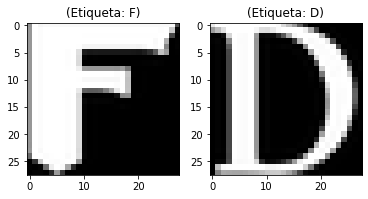

In [10]:
plt.figure(figsize=[6,6])

# Primera imagen en los datos de entrenamiento
plt.subplot(121)
img_idx = 0
curr_img = np.reshape(train_data[img_idx], (28,28))
curr_lbl = train_labels[img_idx]
plt.imshow(curr_img, cmap='gray')
plt.title("(Etiqueta: " + str(label_dict[curr_lbl]) + ")")

# Primera imagen en los datos de prueba
plt.subplot(122)
curr_img = np.reshape(test_data[img_idx], (28,28))
curr_lbl = test_labels[img_idx]
plt.imshow(curr_img, cmap='gray')
plt.title("(Etiqueta: " + str(label_dict[curr_lbl]) + ")")

Las imágenes anteriores muestran dos ejemplos de imágenes del conjunto de entrenamiento y prueba, que tienen asignadas etiquetas de clase `5` o `F` en el primer caso, y `3` o `D` en el segundo. Otras letras van a tener etiquetas diferentes, pero las que son similares entre si tendrán la misma etiqueta. Esto significa que todas las 6.000 imágenes de `F` van a tener una etiqueta de clase `5`

## Preprocesamiento de los datos

Las imágenes del dataset están en escala de grises con valores de pixel en el rango [0, 255] con una dimensión de 28 x 28, por lo que antes de pasarlas como _input_ a la red es necesario preprocesarlas. Primero vamos a convertir cada imagen de los conjuntos de entrenamiento y prueba en una matriz de 28 x 28 x 1:

In [11]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Tenemos que asegurarnos en que el tipo de los datos es `float32`. No es necesario realizar la conversión pues hicimos eso al leer los datos, pero siempre conviene verificar que está en el formato correcto:

In [12]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

Ahora tenemos que reescalar los valores de los pixel al rango [0, 1], para esto verificamos los valores máximos en los arrays, hacemos la normalización, y verificamos:

In [13]:
print(np.max(train_data), np.max(test_data))
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)
print(np.max(train_data), np.max(test_data))

255.0 255.0
1.0 1.0


Habiendo normalizado los datos, es momento de realizar la partición de los datos de entrenamiento en los conjuntos de entrenamiento y validación. Utilizaremos el 80% de los datos para entrenar y los validaremos con el 20% de los datos restantes.

Esto ayudará a reducir las posibilidades de sobreajuste, al validar el modelo con datos que no fueron utilizados en la etapa de entrenamiento. Usaremos el módulo `train_test_split` de scikit-learn para dividir los datos:

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

Hay que tener en cuenta que para esta tarea, no necesitamos etiquetas de entrenamiento y prueba. Por eso pasamos las imágenes de entrenamiento dos veces. Sus imágenes de entrenamiento actuarán tanto como entrada como como salida, en forma similar a las etiquetas en la tarea de clasificación.

## Encoder convolucional

Inicialmente las imágenes estaban en un vector de dimensión 784 (28 x 28 x 1), que fueron convertidas a una matriz de 28 x 28 y reescaladas al rango [0, 1]. Este será el _input_ de la red.

Para el entrenamiento usaremos un batch de tamaño 128, aunque es preferible un tamaño mayor (256 o 512) pero esto depende del sistema disponible para entrenar el modelo. El tamaño del batch afecta notablemente en los parámetros de aprendizaje y en la precisión de la predicción. Entrenaremos al modelo en 50 épocas.

In [15]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

La estructura de la red se dividirá en dos partes:

__Encoder__:
 
- La primer capa es de 32 filtros de tamaño 3 x 3 seguida de una capa de submuestreo (_max-pooling_ o combinación máxima).
- La segunda capa tiene 64 filtros de tamaño 3 x 3, seguida de otra capa de submuestreo.
- La capa final del encoder tiene 128 filtros de tamaño 3 x 3.

__Decoder__:

- La primera capa es de 128 filtros de tamaño 3 x 3 seguida de una capa de sobremuestreo.
- La segunda capa es de 64 filtros de tamaño 3 x 3 seguida de otra capa de sobremuestreo.
- La capa final del decoder tiene un filtro de 3 x 3.

La capa _max-pooling_ hace un submuestreo de la entrada reduciéndola a la mitad cada vez que la usamos, mientras que la capa de sobremuestreo duplicará su entrada cada vez que se use.

__Nota__: El número de filtros, el tamaño de los mismos, el número de capas y el número de épocas de entrenamiento son todos hiperparámetros que deben determinarse sobre la base de la experiencia. Es importante hacer nuevos entrenamientos cambiando estos hiperparámetros y medir el desempeño del modelo.

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

Luego de creado el modelo, lo compilamos utilizando el optimizador RMSProp. Esta técnica de optimización basada en gradientes fue propuesta por [Geoffrey Hinton](https://es.wikipedia.org/wiki/Geoffrey_Hinton), uno de los coautores del [paper](https://www.nature.com/articles/323533a0) que propuso 1n 1986 el aprendizaje por _backpropagation_, y consiste en utilizar una media móvil del gradiente al cuadrado para normalizar el gradiente. Esta normalización equilibra el gradiente disminuyendo el paso para gradientes grandes evitando oscilaciones o divergencias, e incrementando el paso para gradientes pequeños para evitar el estancamiento. Una explicación gráfica del algoritmo puede verse en el [video](https://www.coursera.org/lecture/deep-neural-network/rmsprop-BhJlm) de [Andrew Ng](https://es.wikipedia.org/wiki/Andrew_Ng).

![gradiente](https://github.com/gmg-utn/machine-learning/raw/master/encuentro_03/RMSProp.png)

La idea consiste en que en cada iteración $t$ se calculan en el mini-batch $dw$ y $db$. Con estos valores se calculan las medias móviles:

$$ S_{\delta w}^{(t)} = \beta S_{\delta w}^{(t-1)} + (1 - \beta) dw^2 \;(\leftarrow \text{ pequeño, elemento por elemento}) $$
$$ S_{\delta b}^{(t)} = \beta S_{\delta b}^{(t-1)} + (1 - \beta) db^2 \;(\leftarrow \text{ grande, elemento por elemento}) $$
$$ w \leftarrow w - \alpha \frac{dw}{\sqrt{\delta_{\delta w}^{(t)}} + \epsilon} $$

$$ b \leftarrow b - \alpha \frac{db}{\sqrt{\delta_{\delta b}^{(t)}} + \epsilon} $$

donde $\alpha$ es la tasa de aprendizaje, $\beta$ la tasa de decaimiento de la media móvil exponencial y $\epsilon$ un número pequeño para evitar la división por cero. En este [link](https://imgur.com/a/Hqolp#NKsFHJb) se pueden ver algunas animaciones para comparar las velocidades de convergencia.

![rmsprop](https://i.imgur.com/NKsFHJb.gif)

In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Podemos ahora visualizar la estructura de la red usando el método `summary` que muestra el número de parámetros (pesos y _bias_ en cada capa, y también el número total de parámetros del modelo:

In [18]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)        

Con la red armada, la entrenaremos en 50 épocas. El método `fit()` devuelve un objeto que contiene la historia del entrenamiento, que usaremos luego para graficar la función de pérdida durante el entrenamiento, lo que ayudará a evaluar el desempeño del modelo en forma visual.

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/50
375/375 [==============================] - 10s 28ms/step - loss: 0.0337 - val_loss: 0.0121
Epoch 2/50
375/375 [==============================] - 10s 27ms/step - loss: 0.0101 - val_loss: 0.0089
Epoch 3/50
375/375 [==============================] - 10s 27ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 4/50
375/375 [==============================] - 10s 27ms/step - loss: 0.0058 - val_loss: 0.0064
Epoch 5/50
375/375 [==============================] - 10s 27ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 6/50
375/375 [==============================] - 10s 27ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 7/50
375/375 [==============================] - 10s 27ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 8/50
375/375 [==============================] - 10s 27ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/50
375/375 [==============================] - 10s 27ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/50
375/375 [==============================] - 10s 27ms/step - loss: 0.003

## Función de pérdida
Comparamos la evolución de la función de pérdida durante el entrenamiento y validación:

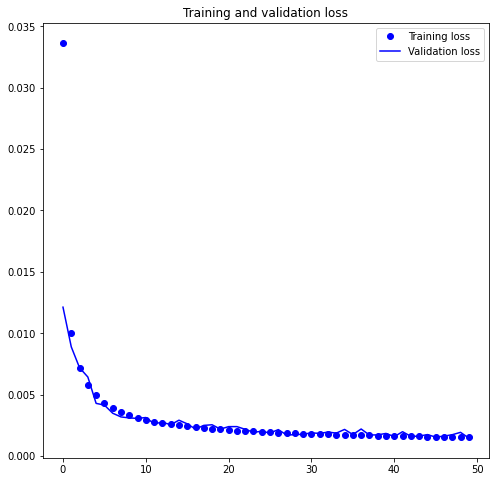

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure(figsize=[8,8])
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Podemos ver que la función de pérdida para el entrenamiento y la validación van juntas, lo que indica que no hay sobreajuste. Por lo tanto, la capacidad de generalización del modelo es buena.

## Predicción de los datos de prueba
Vamos a utilizar el modelo entrenado para predecir las 10.000 imágenes de prueba, y visualizaremos las imágenes reconstruidas para ver qué tan bien funciona la red.

In [21]:
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Imáágenes de prueba


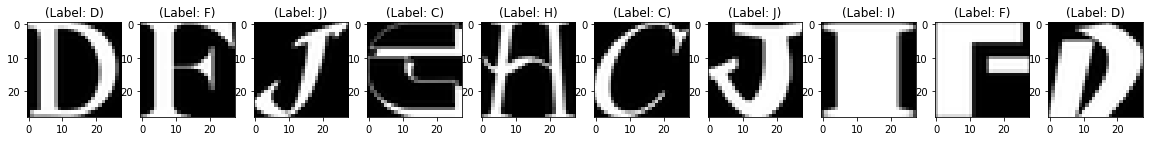

Reconstrucción de imágenes de prueba


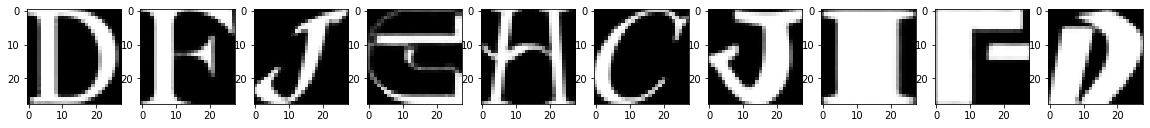

In [22]:
plt.figure(figsize=(20, 4))
print("Imáágenes de prueba")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstrucción de imágenes de prueba")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

De estas imágenes se puede ver que el modelo realiza un buen trabajo en la reconstrucción de las imágenes. 

## Autoencoder de eliminación de ruido

Un autoencoder de eliminación de ruido intenta aprender una representación (el espacio latente o _bottleneck_) que es robusta al ruido. Para ello sumaremos ruido a las imágenes y alimentaremos el _input_ de la parte de encoder de la red, que transformará estas imágenes en un espacio diferente que intentará preservar las letras pero removerá el ruido.

Para el entrenamiento definiremos una función de pérdida RMSprop, y en cada iteración la red calculará la pérdida entre la imagen ruidosa y la imagen original, tratando de minimizar la diferencia entre la imagen reconstruida.

## Agregando ruido a las imágenes
Definiremos como un nuevo hiperparámetro al factor de ruido, obtenido con una matriz con media $0.0$ y desviación estándar $1.0$ de una distribución normal.

Como ejemplo, la variable `train_x`tiene una forma de 48.000 x 28 x 28 x 1. Entonces, el array con distribución normal tendrá la misma forma que `train_x` y las imágenes ruidosas se obtienen sumando ambos arrays:

In [23]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

El método `np.clip()` cortará todos los valores negativos en cero y los valores mayores que uno en uno, de modo de tener siempre los pixeles entre cero y uno.

## Visualización de imágenes ruidosas

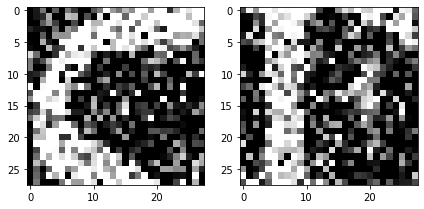

In [24]:
plt.figure(figsize=[7,7])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

## Estructura de la red
Como en el caso anterior, el autoencoder se divide en dos partes: el encoder y el decoder. Para cada parte, usaremos las siguientes capas

__Encoder__:

- La primera capa tiene 32 filtros 3 x 3 seguidos por una capa de submuestreo (_max-pooling_)
- La segunda capa tiene 64 filtros 3 x 3 seguidos por otra capa de submuestreo (_max-pooling_)
- La capa final tiene 128 filtros de 3 x 3

__Decoder__:

- La primera capa tiene 128 filtros seguidos por una capa de sobremuestreo
- La segunda capa tiene 64 filtros seguidos por otra capa de sobremuestreo
- La capa final del decoder tiene un filtro 3 x 3.

Entrenaremos a la red con un tamaño de batch de 128 durante 20 épocas.

In [25]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [26]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [27]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

En el autoencoder tradicional se entrena a la red usando el mismo conjuntos de datos para la entrada y para comparar la salida. En este caso, alimentaremos la red con las imágenes con ruido pero usaremos el conjunto original para calcular la función de pérdida:

In [28]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Epoch 1/20
375/375 [==============================] - 10s 28ms/step - loss: 0.0517 - val_loss: 0.0277
Epoch 2/20
375/375 [==============================] - 10s 27ms/step - loss: 0.0241 - val_loss: 0.0207
Epoch 3/20
375/375 [==============================] - 10s 27ms/step - loss: 0.0206 - val_loss: 0.0194
Epoch 4/20
375/375 [==============================] - 10s 27ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 5/20
375/375 [==============================] - 10s 27ms/step - loss: 0.0178 - val_loss: 0.0168
Epoch 6/20
375/375 [==============================] - 10s 27ms/step - loss: 0.0170 - val_loss: 0.0166
Epoch 7/20
375/375 [==============================] - 10s 27ms/step - loss: 0.0165 - val_loss: 0.0173
Epoch 8/20
375/375 [==============================] - 10s 27ms/step - loss: 0.0160 - val_loss: 0.0159
Epoch 9/20
375/375 [==============================] - 10s 27ms/step - loss: 0.0156 - val_loss: 0.0167
Epoch 10/20
375/375 [==============================] - 10s 27ms/step - loss: 0.015

## Comparación de la pérdida en entrenamiento y validación 

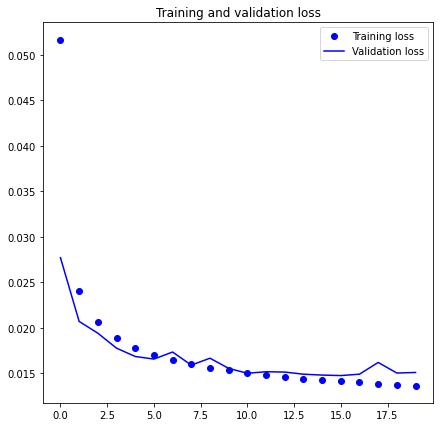

In [29]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure(figsize=[7,7])
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

De la figura anterior puede apreciarse que el modelo sobreajusta en algunas èpocas, aunque se mantienen sincronizadas la mayor parte del entrenamiento. Se puede intentar mejorar el desempeño del modelo introduciendo alguna complejidad de modo de reducir más la pérdida, o entrenando más épocas (o ambas)

## Predicción de los datos de prueba

In [30]:
pred = autoencoder.predict(x_test_noisy)

Imágenes de prueba


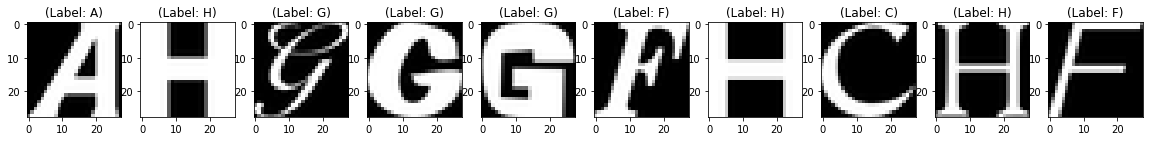

Imágenes de prueba con ruido


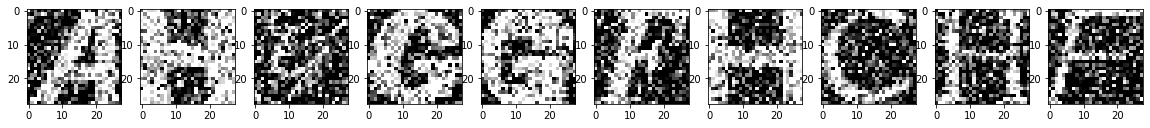

Reconstrucción de las imágenes de prueba con ruido


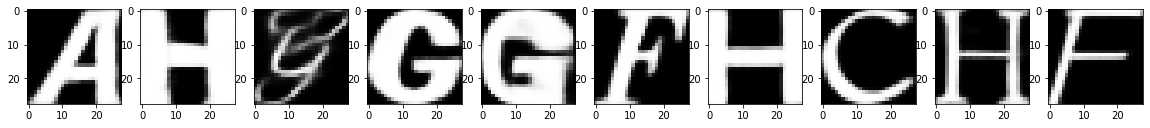

In [31]:
plt.figure(figsize=(20, 4))
print("Imágenes de prueba")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Imágenes de prueba con ruido")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstrucción de las imágenes de prueba con ruido")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()
